In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm


NEED_TRAIN = False

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import sklearn
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image
import math
from fastai.vision.all import *

In [3]:
config = {
    
    'batch_size': 4,
    'n_jobs':4,
    'model': 'swin_large_patch4_window7_224_in22k',
    'seed':350,
    'folds':5,
    'do_smoothing':True,
    'smoothing':0.001
}

if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')

!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22k.pth'

In [4]:


seed = config['seed']
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True
set_seed(seed,reproducible=True)



In [5]:
#model = torch.load('../input/convnext-weights/convnext/convnext_large_22k_224.pth')

<AxesSubplot:>

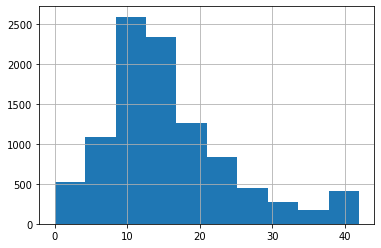

In [6]:
train_dir = '../input/petfinder-pawpularity-score/train/'
test_dir = '../input/petfinder-pawpularity-score/test/'

train_csv = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test_csv = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
submission = pd.read_csv('../input/petfinder-pawpularity-score/sample_submission.csv')

train_csv['norm_score'] = train_csv['Pawpularity']/100.00
if config['do_smoothing']:
    train_csv['norm_score'] = train_csv['norm_score'].apply(lambda x: x * (1.0 - config['smoothing']) + 0.5 *config['smoothing'] )

test_csv['Pawpularity'] = [1]*len(test_csv)
#test_csv['norm_score'] = test_csv['Pawpularity']/100.00
# Path of every image
def create_path(df,root_dir):
    df['Path'] = df['Id'].apply(lambda x: root_dir+x+'.jpg')
    
create_path(train_csv,train_dir)
create_path(test_csv,test_dir)
train_csv = train_csv.drop(columns=['Id'])
test_csv = test_csv.drop(columns=['Id'])
train_csv = train_csv.sample(frac=1).reset_index(drop=True)

# Create Label column (used later)
test_csv['Pawpularity'] = 0

#train_csv.columns
dense_feats = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

#Rice Rule
num_bins = int(np.ceil(2*((len(train_csv))**(1./3))))


train_csv['bins'] = pd.cut(train_csv['norm_score'], bins=num_bins, labels=False)
train_csv['bins'].hist()

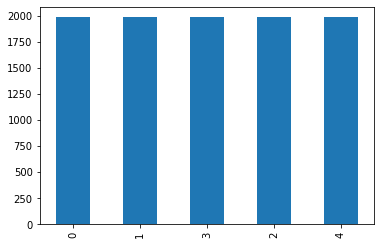

In [7]:
from sklearn.model_selection import StratifiedKFold
train_csv['fold'] = -1
N_FOLDS = config['folds']
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_csv.index, train_csv['bins'])):
    train_csv.iloc[train_index, -1] = i
    
train_csv['fold'] = train_csv['fold'].astype('int') 
train_csv.fold.value_counts().plot.bar()

def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [8]:
train_csv.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,norm_score,Path,bins,fold
0,0,0,1,1,0,0,0,0,0,0,1,0,38,0.38012,../input/petfinder-pawpularity-score/train/6d11d1d203f4f67b070ca0eaf4f42b89.jpg,16,3
1,0,1,1,1,0,0,0,0,0,0,0,0,30,0.30020,../input/petfinder-pawpularity-score/train/947c361bb9535e78706a1fa2f82bd82a.jpg,12,2
2,0,1,1,1,0,1,0,0,1,0,0,0,30,0.30020,../input/petfinder-pawpularity-score/train/678359258627d0968f43d87759401634.jpg,12,0
3,0,1,1,1,0,0,0,0,0,0,0,0,37,0.37013,../input/petfinder-pawpularity-score/train/b285df6b825d55eb6fe2da7ec613f719.jpg,15,0
4,0,1,1,1,0,1,0,0,0,0,0,0,60,0.59990,../input/petfinder-pawpularity-score/train/7bd8e3df5ce91d4cf12c138b67ec8200.jpg,25,3


In [9]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/convnext/')
import timm
import models.convnext
import models.convnext_isotropic
import utils
import torch
from torch import nn

class ImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class=1, in_channels=3,pretrained_path=''):
        super().__init__()
        self.model = timm.create_model(model_arch,in_chans=in_channels, pretrained=False)
        self.model=self.load_pretrain(self.model,pretrained_path)
        num_ftrs = self.model.head.in_features
        self.model.head = nn.Linear(num_ftrs, n_class)
    def load_pretrain(self,model,pretrained_path):
        checkpoint = torch.load(pretrained_path, map_location='cpu')
        print("Load ckpt from %s" % pretrained_path)
        checkpoint_model = checkpoint['model']
        state_dict = model.state_dict()
        for k in ['head.weight', 'head.bias']:
            if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]
        utils.load_state_dict(model, checkpoint_model, prefix='')
        return model
    def forward(self, x):
        x = self.model(x)
        x=x.flatten()
        return x

# !wget https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_384.pth


In [10]:
def get_data(fold):
    train_csv_f = train_csv.copy()
    train_csv_f['is_valid'] = (train_csv_f['fold'] == fold)
    
    
    val_idx = train_csv_f[train_csv_f['is_valid']].index.values
    dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                get_x=ColReader('Path'),
                get_y=ColReader('norm_score'),
                splitter=IndexSplitter(val_idx),
                item_tfms=Resize(224), #pass in item_tfms
                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
               )
                             
    paw_dls = dls.dataloaders(train_csv_f, 
                              bs=config['batch_size'],
                              num_workers=config['n_jobs'],
                              seed=seed)   
                             
    return paw_dls, IndexSplitter(val_idx)          

In [11]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/convnext/')
import timm
import models.convnext
import models.convnext_isotropic
import utils
import torch
from torch import nn

class ImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class=1, in_channels=3,pretrained_path=''):
        super().__init__()
        self.model = timm.create_model(model_arch,in_chans=in_channels, pretrained=False)
        self.model=self.load_pretrain(self.model,pretrained_path)
        num_ftrs = self.model.head.in_features
        self.model.head = nn.Linear(num_ftrs, n_class)
    def load_pretrain(self,model,pretrained_path):
        checkpoint = torch.load(pretrained_path, map_location='cpu')
        print("Load ckpt from %s" % pretrained_path)
        checkpoint_model = checkpoint['model']
        state_dict = model.state_dict()
        for k in ['head.weight', 'head.bias']:
            if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]
        utils.load_state_dict(model, checkpoint_model, prefix='')
        return model
    def forward(self, x):
        x = self.model(x)
        x=x.flatten()
        return x

# !wget https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_384.pth
#model=ImgClassifier(model_arch='convnext_large',pretrained_path='../input/convnext-weights/convnext/convnext_large_22k_224.pth')

In [12]:


def get_learner(fold):
    data,splitter = get_data(fold)
    #model = timm.create_model(config['model'],pretrained = True,num_classes = data.c)
    #model = torch.load('../input/convnext-weights/convnext/convnext_large_22k_224.pth')
    model=ImgClassifier(model_arch='convnext_large',pretrained_path='../input/convnext-weights/convnext/convnext_large_22k_224.pth')
    
    #model = nn.Sequential(model,nn.Linear(model.in_features,1))
    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse, cbs=[MixUp(0.2)]).to_fp16()
    return learn,splitter



if len(test_csv) != 8:
    NEED_TRAIN = True



In [13]:
import gc

from sklearn.metrics import mean_squared_error
#NEED_TRAIN = True

if NEED_TRAIN:
    all_preds = []
    train_csv['pred'] = -1

    for i in range(N_FOLDS):

        print(f'Fold {i} results')
        learn, splitter = get_learner(fold=i)
        learn.fit_one_cycle(4, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
        learn.recorder.plot_loss()
        learn.export(f'model_fold_{i}.pkl')
        dls = DataBlock(blocks=(ImageBlock, RegressionBlock),
                    get_x=ColReader('Path'),
                    get_y=ColReader('norm_score'),
                    splitter=RandomSplitter(0.2),
                    item_tfms=Resize(224), #pass in item_tfms
                    batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])
                   )
        paw_dls = dls.dataloaders(train_csv, 
                              bs=config['batch_size'],
                              num_workers=4,
                              seed=seed)
        
        test_dl = paw_dls.test_dl(test_csv)

        preds, _ = learn.tta(dl=test_dl, n=5, beta=0)

        all_preds.append(preds)
        
        val_idx = splitter(range(len(train_csv)))[1]
        val_df = train_csv.loc[val_idx]
        val_pred, _ = learn.tta(dl=paw_dls.test_dl(val_df), n=5, beta=0)
        print(val_df['Pawpularity'][:5], val_pred[:5])
        score = mean_squared_error(val_df['Pawpularity'], val_pred*100, squared=False)
        print(f'Fold {i} | Score: {score}')
        # Save prediction of validation as pred
        #train_csv.loc[val_idx, 'pred'] = val_pred*100

        del learn

        torch.cuda.empty_cache()

        gc.collect()
        
        #Only run one fold for public train as we don't have so many GPU time
        if len(test_csv) == 8:
            break
#         if len(test_csv) == 8:
#             cv_score = mean_squared_error(train_csv.loc[train_csv['pred']!=-1, 'Pawpularity'], 
#                                           train_csv.loc[train_csv['pred']!=-1, 'pred'], squared=False)
#             print(f'CV Score: {cv_score}')

if NEED_TRAIN:
    all_preds, np.mean(np.stack(all_preds*100))

sample_df = pd.read_csv('../input/petfinder-pawpularity-score/sample_submission.csv')
if NEED_TRAIN:
    preds = np.mean(np.stack(all_preds), axis=0)
    sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

if not NEED_TRAIN:
    pd.read_csv('submission.csv').head()

In [14]:
sample_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


In [15]:
train_csv

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,norm_score,Path,bins,fold
0,0,0,1,1,0,0,0,0,0,0,1,0,38,0.38012,../input/petfinder-pawpularity-score/train/6d11d1d203f4f67b070ca0eaf4f42b89.jpg,16,3
1,0,1,1,1,0,0,0,0,0,0,0,0,30,0.30020,../input/petfinder-pawpularity-score/train/947c361bb9535e78706a1fa2f82bd82a.jpg,12,2
2,0,1,1,1,0,1,0,0,1,0,0,0,30,0.30020,../input/petfinder-pawpularity-score/train/678359258627d0968f43d87759401634.jpg,12,0
3,0,1,1,1,0,0,0,0,0,0,0,0,37,0.37013,../input/petfinder-pawpularity-score/train/b285df6b825d55eb6fe2da7ec613f719.jpg,15,0
4,0,1,1,1,0,1,0,0,0,0,0,0,60,0.59990,../input/petfinder-pawpularity-score/train/7bd8e3df5ce91d4cf12c138b67ec8200.jpg,25,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,1,1,1,0,0,0,0,1,1,0,0,25,0.25025,../input/petfinder-pawpularity-score/train/bbe3c550fa4601f5f4d4df84182d03af.jpg,10,0
9908,0,0,1,1,0,0,0,0,1,1,0,1,26,0.26024,../input/petfinder-pawpularity-score/train/6fff633ed94d80dd7591361c5a14924e.jpg,10,0
9909,0,1,1,1,0,0,0,0,0,0,0,0,89,0.88961,../input/petfinder-pawpularity-score/train/11a59a38ce928cfc285263455d61797d.jpg,38,0
9910,0,1,1,1,0,0,1,0,0,0,0,0,95,0.94955,../input/petfinder-pawpularity-score/train/74e41a94f4b96eace97323b7634e9060.jpg,40,0
